### Logistic Regression

Logistic Regression is a variation of Linear Regression, useful when the observed dependent variable, y, is categorical. It produces a formula that predicts the probability of the class label as a function of the independent variables.

Despite the name logistic regression, it is actually a probabilistic classification model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

                            𝑃𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦𝑂𝑓𝑎𝐶𝑙𝑎𝑠𝑠 = 𝑡ℎ𝑒𝑡𝑎(𝑦) = 𝑒𝑦1+𝑒𝑦 = 𝑒𝑥𝑝(𝑦)/(1+𝑒𝑥𝑝(𝑦)) = 𝑝
                            
                            
which produces p-values between 0 (as y approaches minus infinity −𝑖𝑛𝑓𝑡𝑦) and 1 (as y approaches plus infinity  +∞ ). This now becomes a special kind of non-linear regression.

You might also have seen this function before, in another configuration:

$$
ProbabilityOfaClass = \\theta(y) = \frac{1}{1+e^{-y}}
$$

So, briefly, Logistic Regression passes the input through the logistic/sigmoid function but then treats the result as a probability:

<img src="https://ibm.box.com/shared/static/kgv9alcghmjcv97op4d6onkyxevk23b1.png" width="400" align="center">


### Utilizing Logistic Regression in TensorFlow

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if not tf.__version__ == '2.3.0':
    print(tf.__version__)
    raise ValueError('please upgrade to TensorFlow 2.3.0, or restart your Kernel (Kernel->Restart & Clear Output)')

Next, we will load the dataset we are going to use. In this case, we are utilizing the iris dataset.

In [3]:
iris = load_iris()

iris_X, iris_y = iris.data[:-1, :], iris.target[:-1]
iris_y = pd.get_dummies(iris_y).values
train_X, test_X, train_Y, test_Y = train_test_split(iris_X, iris_y,
                                                   test_size = 0.3, 
                                                   random_state = 42)

Next we define x and y. These variables will hold our iris data (both the features and label matrices) We also need to give them shapes which correspond to the shape of our data.

In [4]:
numFeatures = train_X.shape[1] # Number of features, 4
numLabels = train_Y.shape[1] # Number of classes, 3


In [5]:
# Iris has 4 features, so X is a tensor to hold our data.
#X = tf.Variable( np.identity(numFeatures), tf.TensorShape(numFeatures),
#dtype='float32') 

# This will be our correct answers matrix for 3 classes.
#yGold = tf.Variable(np.array([1,1,1]),shape=tf.TensorShape(numLabels),
#dtype='float32') 

In [6]:
train_X = tf.constant(train_X, dtype = 'float32')
train_Y = tf.constant(train_Y, dtype = 'float32')
test_X = tf.constant(test_X, dtype = 'float32')
test_Y = tf.constant(test_Y, dtype = 'float32')

### Set model weights and bias

Much like Linear Regression, we need a shared variable weight matrix for Logistic Regression. We initialize both `W` and `b` as tensors full of zeros. Since we are going to learn `W` and `b`, their initial value does not matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they have been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training. 

Notice that `W` has a shape of [4, 3] because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. `b` has a shape of [3] so we can add it to the output. TensorFlow variables need to be initialized with values, e.g. with zeros.

In [7]:
W = tf.Variable(tf.zeros([4, 3])) # 4 dimentional input and 3 classes
b = tf.Variable(tf.zeros([3])) # 3 dimentional output [0,0,1],[0,1,0],[1,0,0]

In [8]:
# Randomly sample from a normal distribution with std 0.01

weights = tf.Variable(tf.random.normal([numFeatures, numLabels],
                                      mean = 0.0,
                                      stddev = 0.01,
                                      name = 'weights'), dtype = 'float32')

bias = tf.Variable(tf.random.normal([1, numLabels],
                                      mean = 0.0,
                                      stddev = 0.01,
                                      name = 'bias'))

### Logistic Regression model

We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

We can have it broken into its three main components: 

-   a weight times features matrix multiplication operation, 
-   a summation of the weighted features and a bias term, 
-   and finally the application of a sigmoid function. 

As such, you will find these components defined as three separate operations below.


In [9]:
def logistic_regression(x):
    apply_weights_OP = tf.matmul(x, weights, name = 'apply_weights')
    add_bias_OP = tf.add(apply_weights_OP, bias, name = 'add_bias')
    #the logistic function in tensorflow is implimented as nn.sigmoid
    activation_OP = tf.nn.sigmoid(add_bias_OP, name = 'activation')
    return activation_OP

### Training
The learning algorithm is how we search for the best weight vector ( 𝑏𝑓𝑤 ). This search is an optimization problem looking for the hypothesis that optimizes an error/cost measure.

#### What tell us our model is bad?
The Cost or Loss of the model, so what we want is to minimize that.

#### Cost function
Before defining our cost function, we need to define how long we are going to train and how should we define the learning rate.

In [10]:
# Defining the learning rate iteration
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0008,
                                                              decay_steps = train_X.shape[0],
                                                              decay_rate = 0.95,
                                                              staircase = True)

The **cost function** we are going to utilize is the Squared Mean Error loss function.

How to minimize the cost function?
We can't use least-squares linear regression here, so we will use gradient descent instead. Specifically, we will use batch gradient descent which calculates the gradient from all data points in the data set.

In [11]:
# Defining the cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learning_rate)

We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:

In [12]:
# Accuracy metric
def accuracy(y_pred, y_true):
    # Predicted class is the index of the highest score in prediction vector
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

- First wrap computation inside a GradientTape for automatic differentiation.
- Then compute gradients and update W and b.

In [13]:
# Optimization process

def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = loss_object(pred, y)
    gradients = g.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

Now we move on to actually running our operations. We will start with the operations involved in the prediction phase (i.e. the logistic regression itself).

Now we can define and run the actual training loop:

In [14]:
# Initialize reporting variables

epochs = 700 # Number of Epochs in our training
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1

# Training epochs
for i in range(epochs):
    if i > 1 and diff < 0.0001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        run_optimization(train_X, train_Y)
        
        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            
            pred = logistic_regression(test_X)
            
            new_loss = loss_object(pred, test_Y)
            # Add loss to live graphing variable
            loss_values.append(new_loss)
            
            # Generate accuracy stats on test data
            acc = accuracy(pred, test_Y)
            accuracy_values.append(acc)
            
    
            # Re-assign values for variables
            diff = abs(new_loss - loss)
            loss = new_loss

            #generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, new_loss, diff))

        

          

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %acc.numpy())



step 0, training accuracy 0.0444444, loss 0.13631, change in loss 0.13631
step 10, training accuracy 0.155556, loss 0.135755, change in loss 0.0005555
step 20, training accuracy 0.266667, loss 0.135207, change in loss 0.000547603
step 30, training accuracy 0.266667, loss 0.134667, change in loss 0.000539675
step 40, training accuracy 0.288889, loss 0.134136, change in loss 0.000531733
step 50, training accuracy 0.288889, loss 0.133612, change in loss 0.000523835
step 60, training accuracy 0.288889, loss 0.133096, change in loss 0.000515878
step 70, training accuracy 0.288889, loss 0.132588, change in loss 0.000507966
step 80, training accuracy 0.288889, loss 0.132088, change in loss 0.000500053
step 90, training accuracy 0.288889, loss 0.131596, change in loss 0.00049217
step 100, training accuracy 0.288889, loss 0.131111, change in loss 0.000484303
step 110, training accuracy 0.288889, loss 0.130651, change in loss 0.000459939
step 120, training accuracy 0.288889, loss 0.130206, chang

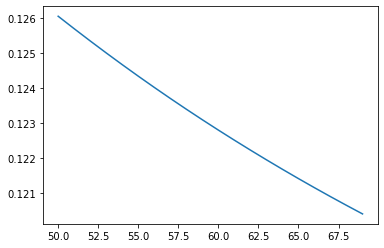

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Plot the loss
plt.plot([np.mean(loss_values[i-50:i]) for i in range(len(loss_values))])
plt.show()